In [2]:
# !pip install -U torch torchvision -f https://download.pytorch.org/whl/torch_stable.html 
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install cython pyyaml
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-u90vfui5
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-u90vfui5
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263922 sha256=aea9224d1e33a27988ea99bdecf20bb9ed2ad969760237709e086108debddb20
  Stored in directory: /tmp/pip-ephem-wheel-cache-saomr5a6/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.3
    Uninstalling pycocotools-2.0.3:
      Successfully uninstalled pycocotools-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
detectron2 0.6+cu111 requires pycocotools>=2.0.2, but you have py

In [3]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu113
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
  Using cached pycocotools-2.0.3-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [4]:
import detectron2

# import some common libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo # load a model from COCO model ZOO
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x.yaml")

predictor = DefaultPredictor(cfg)

1920.0
1080.0
Resizing to:  (1920, 1080)


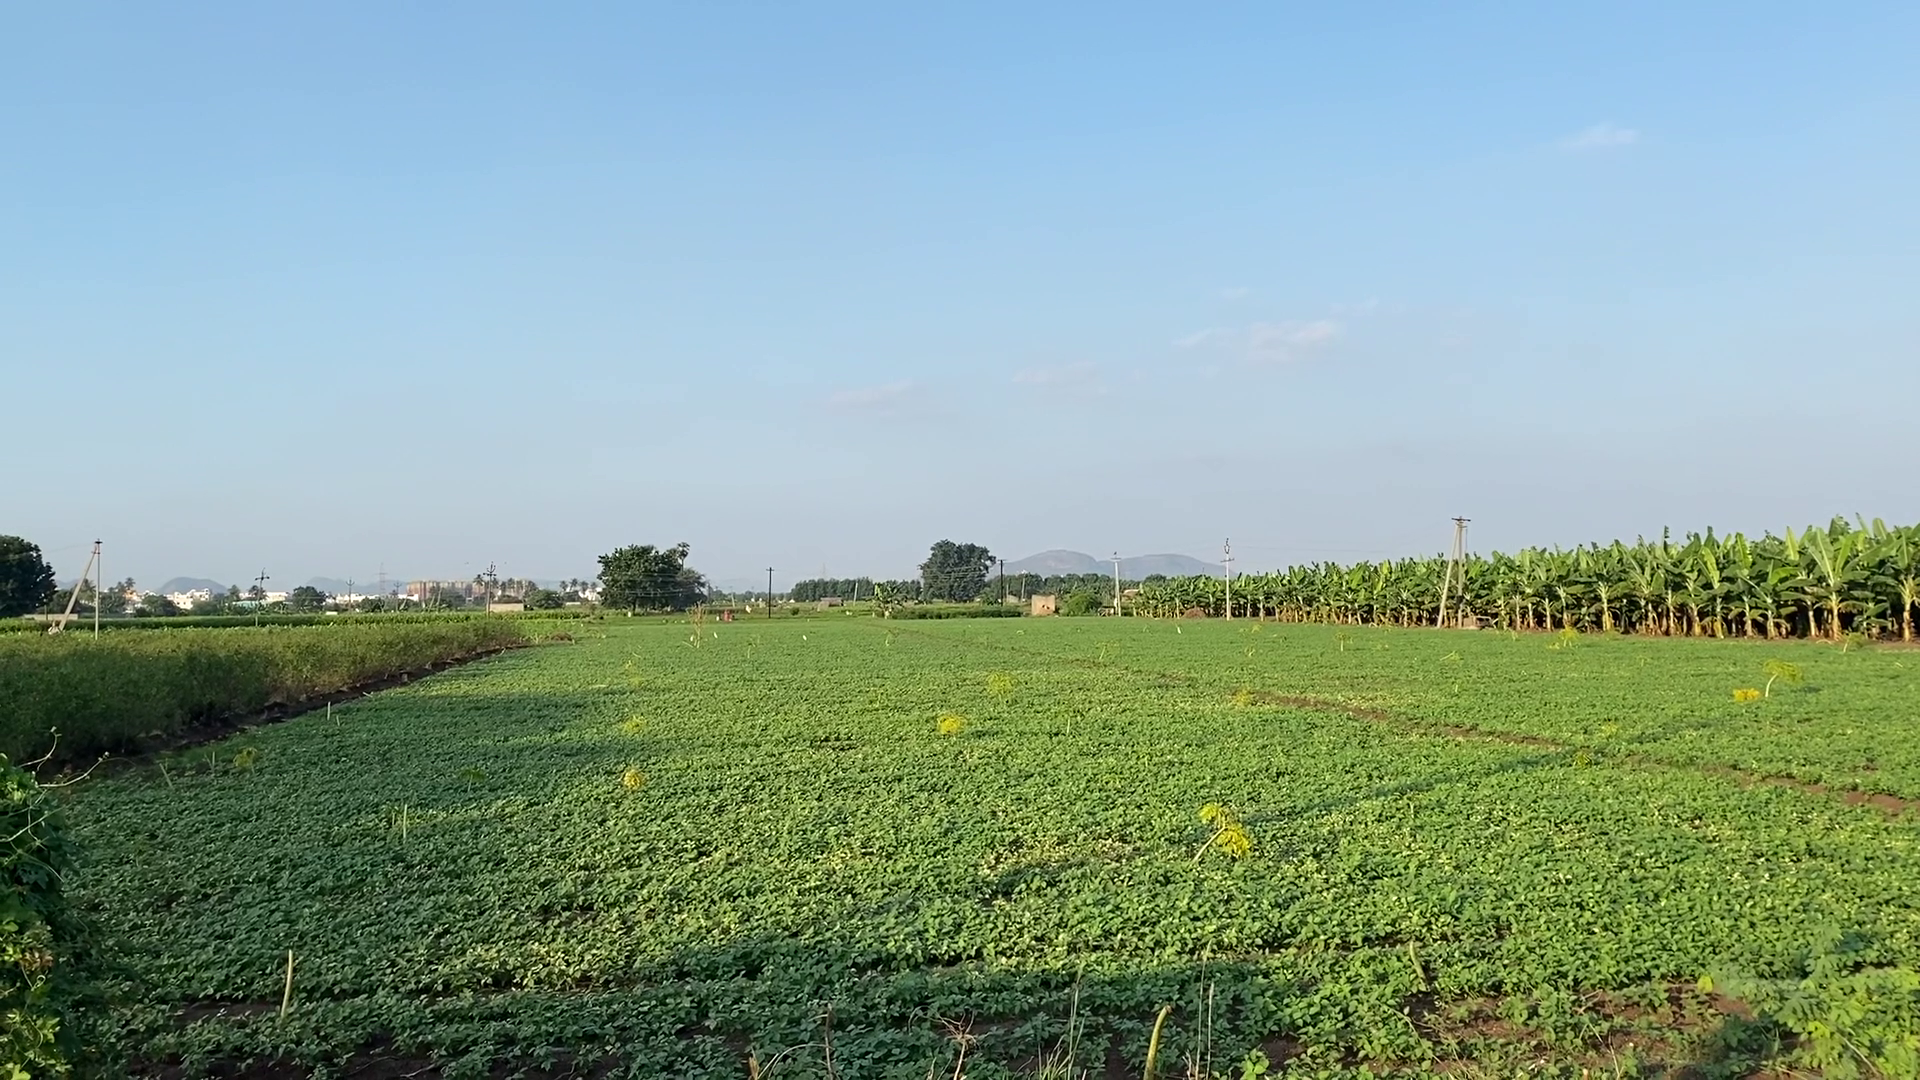

In [12]:
import cv2
import time
from scipy import ndimage

# open video stream
cap = cv2.VideoCapture(r'/content/drive/MyDrive/Prism/take_noob_3.MOV') # change as appropriate

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

current_frame = 0

# rescale for better performances
WIDTH = cap.get(3)
print(WIDTH)
HEIGHT = cap.get(4)
print(HEIGHT)
FPS = cap.get(5)
SCALE_RATIO = 59 # percent from original size

SCALED_WIDTH = int(WIDTH * SCALE_RATIO / 100)
SCALED_HEIGHT = int(HEIGHT * SCALE_RATIO / 100)

DIM = (SCALED_WIDTH, SCALED_HEIGHT)
DIM = (1920, 1080)
print("Resizing to: ", DIM)

#cv2.startWindowThread()

# writing the output to a video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, DIM)

n_frame = 0

# first frame is too dark, taking the 19th frame as anchor point
while True:
    _, frame = cap.read()
    n_frame += 1

    if n_frame == 20:
        # frame = cv2.rotate(frame, cv2.ROTATE_180)
        frame = cv2.resize(frame, DIM)
        first_frame = frame
        break

cv2_imshow(first_frame)

In [13]:
while True:
    
    print("Processing frame %s of %s" %(current_frame, total_frames), flush=True)
    
    # Capture frame-by-frame
    _, frame = cap.read()

    # resizing for faster detection
    # frame = cv2.rotate(frame, cv2.ROTATE_180)
    frame = cv2.resize(frame, DIM)
    

    # using a greyscale picture, also for faster detection
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # detect people in the image
    
    # returns the bounding boxes for the detected objects
    outputs = predictor(frame)
    outputs = outputs["instances"].pred_boxes.to('cpu').tensor.numpy().astype(int)

    # iterate over each detected person and
    # substitute the area with the first frame
    original = frame.copy()
    rectangle = frame.copy()
    
    for (x, y, w, h) in outputs:

        crop_img = first_frame[y:y + h, x:x + w]
        frame[y:y + h, x:x + w] = crop_img
        
        # could also write
        # frame[y:y + h, x:x + w] = first_frame[y:y + h, x:x + w]

        # for debugging show bounding rectangle
        cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(rectangle, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    #cv2_imshow(frame)
    out.write(frame)
    
    # also for debugging
    # cv2_imshow(frame)
    # cv2_imshow('First Frame', first_frame)
    # cv2_imshow('CLean Frame', original)
    # cv2_imshow('Rectangle Frame', rectangle)
    print('Writing to frame')
    
    
    current_frame += 1
    
    del(frame, gray, outputs, original, rectangle) # empty memory
    
    if current_frame == total_frames:
        break

# and release the output
out.release()

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Processing frame 0 of 306
Writing to frame
Processing frame 1 of 306
Writing to frame
Processing frame 2 of 306
Writing to frame
Processing frame 3 of 306
Writing to frame
Processing frame 4 of 306
Writing to frame
Processing frame 5 of 306
Writing to frame
Processing frame 6 of 306
Writing to frame
Processing frame 7 of 306
Writing to frame
Processing frame 8 of 306
Writing to frame
Processing frame 9 of 306
Writing to frame
Processing frame 10 of 306
Writing to frame
Processing frame 11 of 306
Writing to frame
Processing frame 12 of 306
Writing to frame
Processing frame 13 of 306
Writing to frame
Processing frame 14 of 306
Writing to frame
Processing frame 15 of 306
Writing to frame
Processing frame 16 of 306
Writing to frame
Processing frame 17 of 306
Writing to frame
Processing frame 18 of 306
Writing to frame
Processing frame 19 of 306
Writing to frame
Processing frame 20 of 306
Writing to frame
Processing frame 21 of 306
Writing to frame
Processing frame 22 of 306
Writing to fram

error: ignored